# Importing Libraries and Downloading Data

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
import nltk
from math import sqrt

def download_data(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        df = df['Close'].rename(ticker)
        return df
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.Series(name=ticker)

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=20*365)).strftime('%Y-%m-%d')

tickers = ['FRSH', 'NEM', 'XOM', 'INR=X']

dataframes = [download_data(ticker, start_date, end_date) for ticker in tickers]
merged_data = pd.concat(dataframes, axis=1).dropna()
merged_data.columns = ['FRESHWORKS', 'GOLD', 'PETROL', 'CURRENCY']

merged_data.to_csv('merged_data.csv')

if merged_data.isna().any().any():
    print("Warning: NaN values present in the merged data.")
else:
    print("Data downloaded and merged successfully.")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data downloaded and merged successfully.


# Data Preprocessing and Linear Regression

c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


FRESHWORKS    float64
GOLD          float64
PETROL        float64
CURRENCY      float64
dtype: object
            FRESHWORKS       GOLD     PETROL   CURRENCY
Date                                                   
2021-09-22   47.549999  54.650002  55.209999  73.792702
2021-09-23   47.540001  54.049999  57.080002  73.874901
2021-09-24   46.750000  53.869999  57.590000  73.839996
2021-09-27   44.049999  53.900002  59.299999  73.812897
2021-09-28   42.730000  54.580002  59.919998  73.825302
Actual vs. Predicted Values:
            Actual RELIANCE  Predicted RELIANCE
Date                                           
2022-11-09        12.800000           17.531710
2024-04-29        18.420000           12.716728
2022-09-29        13.500000           22.826500
2023-01-24        15.310000           12.109328
2022-12-27        13.780000           12.904814
...                     ...                 ...
2023-01-19        15.170000           13.138969
2023-09-27        19.295000           14.7963

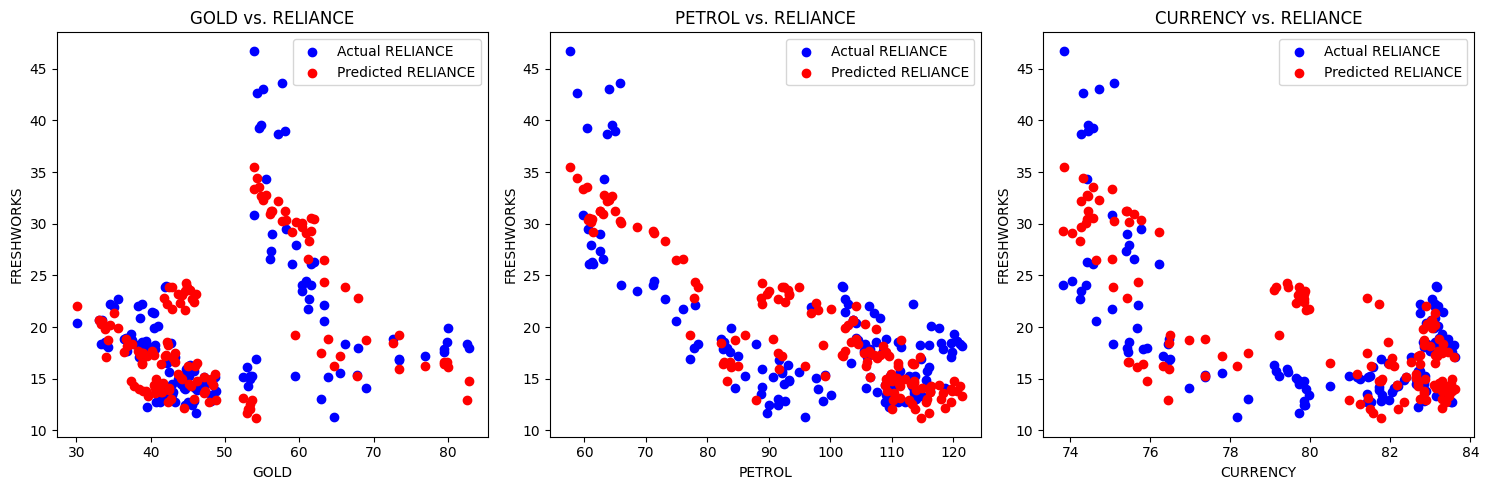

In [2]:
data = pd.read_csv('merged_data.csv')

data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

data.dropna(inplace=True)

print(data.dtypes)

print(data.head())

# Linear Regression


X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results_table = pd.DataFrame({'Actual RELIANCE': y_test, 'Predicted RELIANCE': y_pred})
print("Actual vs. Predicted Values:")
print(results_table)

print(f'\nMean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].scatter(X_test['GOLD'], y_test, color='blue', label='Actual RELIANCE')
axes[0].scatter(X_test['GOLD'], y_pred, color='red', label='Predicted RELIANCE')
axes[0].set_xlabel('GOLD')
axes[0].set_ylabel('FRESHWORKS')
axes[0].set_title('GOLD vs. RELIANCE')
axes[0].legend()

axes[1].scatter(X_test['PETROL'], y_test, color='blue', label='Actual RELIANCE')
axes[1].scatter(X_test['PETROL'], y_pred, color='red', label='Predicted RELIANCE')
axes[1].set_xlabel('PETROL')
axes[1].set_ylabel('FRESHWORKS')
axes[1].set_title('PETROL vs. RELIANCE')
axes[1].legend()

axes[2].scatter(X_test['CURRENCY'], y_test, color='blue', label='Actual RELIANCE')
axes[2].scatter(X_test['CURRENCY'], y_pred, color='red', label='Predicted RELIANCE')
axes[2].set_xlabel('CURRENCY')
axes[2].set_ylabel('FRESHWORKS')
axes[2].set_title('CURRENCY vs. RELIANCE')
axes[2].legend()

plt.tight_layout()
plt.show()


# Random Forest Regression

In [3]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

metrics_dict_rf = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]
    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_rf = RandomForestRegressor(random_state=42)
    model_rf.fit(X_train, y_train)

    y_pred_rf = model_rf.predict(X_test)

    mse_rf, rmse_rf, r2_rf = calculate_metrics(y_test, y_pred_rf)

    metrics_dict_rf['Feature'].append(feature)
    metrics_dict_rf['MSE'].append(mse_rf)
    metrics_dict_rf['RMSE'].append(rmse_rf)
    metrics_dict_rf['R-squared'].append(r2_rf)

results_df_rf = pd.DataFrame(metrics_dict_rf)
print(results_df_rf)


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


    Feature        MSE      RMSE  R-squared
0      GOLD  27.912014  5.283182   0.440057
1    PETROL  19.424304  4.407301   0.610329
2  CURRENCY  36.329236  6.027374   0.271199


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# K-Nearest Neighbors Regression

In [4]:
metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]
    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(X_train, y_train)

    y_pred_knn = model_knn.predict(X_test)

    mse_knn, rmse_knn, r2_knn = calculate_metrics(y_test, y_pred_knn)

    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['R-squared'].append(r2_knn)

results_df_knn = pd.DataFrame(metrics_dict_knn)
print(results_df_knn)


    Feature        MSE      RMSE  R-squared
0      GOLD  22.546919  4.748360   0.547686
1    PETROL  14.963734  3.868299   0.699812
2  CURRENCY  26.203433  5.118929   0.474333


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Covolutional Neural Networks

In [5]:
X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))

model_cnn.compile(optimizer='adam', loss='mean_squared_error')

model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_cnn = model_cnn.predict(X_test_cnn).flatten()

mse_cnn, rmse_cnn, r2_cnn = calculate_metrics(y_test, y_pred_cnn)

print("Performance Metrics (CNN):")
print(f'Mean Squared Error (CNN): {mse_cnn}')
print(f'Root Mean Squared Error (CNN): {rmse_cnn}')
print(f'R-squared (CNN): {r2_cnn}')


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Performance Metrics (CNN):
Mean Squared Error (CNN): 13.944814807902118
Root Mean Squared Error (CNN): 3.7342756737956715
R-squared (CNN): 0.7202530308582172


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Artificial Neural Network (ANN) Regression

In [6]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))

model_ann.compile(optimizer='adam', loss='mean_squared_error')

model_ann.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_ann = model_ann.predict(X_test_scaled).flatten()

mse_ann, rmse_ann, r2_ann = calculate_metrics(y_test, y_pred_ann)

results_ann = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices (ANN)': y_pred_ann})

print("Actual and Predicted Prices (ANN):")
print(results_ann.head())
print("\nPerformance Metrics (ANN):")
print(f'Mean Squared Error (ANN): {mse_ann}')
print(f'Root Mean Squared Error (ANN): {rmse_ann}')
print(f'R-squared (ANN): {r2_ann}')


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Actual and Predicted Prices (ANN):
            Actual Prices  Predicted Prices (ANN)
Date                                             
2022-11-09          12.80               13.783706
2024-04-29          18.42               18.957609
2022-09-29          13.50               17.728140
2023-01-24          15.31               12.226051
2022-12-27          13.78               14.793670

Performance Metrics (ANN):
Mean Squared Error (ANN): 12.118315078444901
Root Mean Squared Error (ANN): 3.481137038159357
R-squared (ANN): 0.7568944470758351


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Long Short-Term Memory (LSTM) Regression

Epoch 1/100


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0512 - val_loss: 0.0014
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 7.8618e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 8.8015e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 7.8762e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

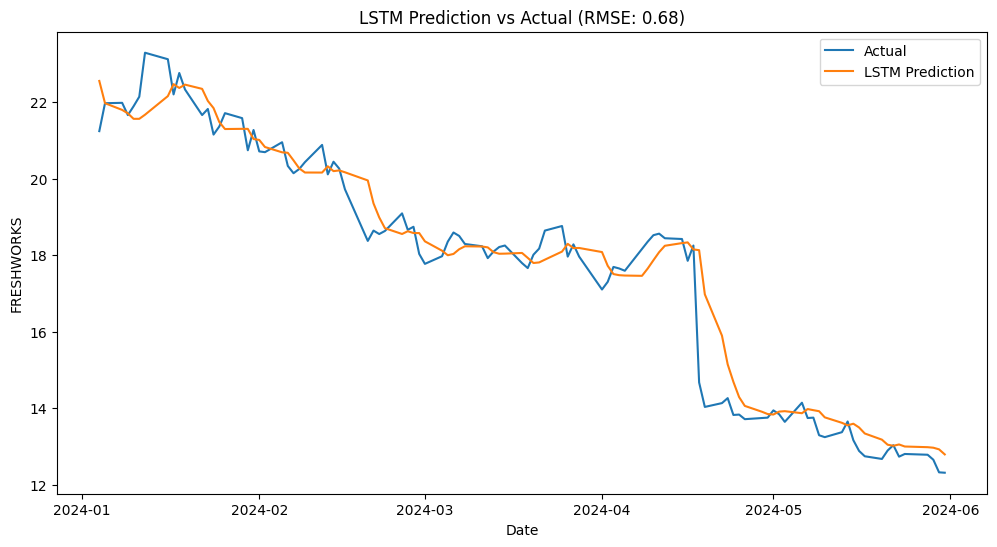

Root Mean Squared Error (RMSE): 0.68
Error Percentage: 3.83%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Forecasted stock prices for the upcoming 7 days:
2024-06-15: 22.55221176147461
2024-06-16: 21.970077514648438
2024-06-17: 21.795042037963867
2024-06-18: 21.704036712646484
2024-06-19: 21.56174659729004
2024-06-20: 21.56207275390625


In [7]:
target_variable = 'FRESHWORKS'

y = data[target_variable].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10

X_seq, y_seq = create_sequences(y_scaled, sequence_length)

train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.15)
test_size = len(X_seq) - train_size - val_size

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

y_pred_lstm = model_lstm.predict(X_test)

y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))

test_dates = data.index[train_size+val_size : train_size+val_size+len(y_test_inv)]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Prediction')
plt.title(f'LSTM Prediction vs Actual (RMSE: {rmse_lstm:.2f})')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.legend()
plt.show()

error_percentage = (rmse_lstm / np.mean(y_test_inv)) * 100
print(f'Root Mean Squared Error (RMSE): {rmse_lstm:.2f}')
print(f'Error Percentage: {error_percentage:.2f}%')

forecasted_values_scaled = []
for i in range(7):
    X_new = np.array([X_test[i]])
    forecasted_value_scaled = model_lstm.predict(X_new)[0][0]
    forecasted_values_scaled.append(forecasted_value_scaled)
    X_test = np.concatenate((X_test, X_new), axis=0)

forecasted_values = scaler.inverse_transform(np.array(forecasted_values_scaled).reshape(-1, 1))
forecasted_dates = pd.date_range(data.index[-1], periods=7, freq='D')[1:]

print("Forecasted stock prices for the upcoming 7 days:")
for date, price in zip(forecasted_dates, forecasted_values):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]}")


In [8]:
target_variable = 'FRESHWORKS'
y = data[target_variable].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10
X_seq, y_seq = create_sequences(y_scaled, sequence_length)

def train_evaluate_lstm(X_train, y_train, X_val, y_val):
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    y_pred_lstm = model_lstm.predict(X_val)
    y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
    y_val_inv = scaler.inverse_transform(y_val)
    mse = mean_squared_error(y_val_inv, y_pred_lstm_inv)
    mae = mean_absolute_error(y_val_inv, y_pred_lstm_inv)
    rmse = np.sqrt(mse)
    error_percentage = (rmse / np.mean(y_val_inv)) * 100
    return mse, mae, rmse, error_percentage

validation_sizes = [5, 10, 15, 20]

evaluation_results = {'Validation Size (%)': validation_sizes,
                      'Mean Squared Error (MSE)': [],
                      'Mean Absolute Error (MAE)': [],
                      'Root Mean Squared Error (RMSE)': [],
                      'Error Percentage (%)': []}

for val_size in validation_sizes:
    train_size = int(len(X_seq) * (1 - val_size / 100))
    val_size = int(len(X_seq) * (val_size / 100))
    test_size = len(X_seq) - train_size - val_size
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
    mse, mae, rmse, error_percentage = train_evaluate_lstm(X_train, y_train, X_val, y_val)
    evaluation_results['Mean Squared Error (MSE)'].append(mse)
    evaluation_results['Mean Absolute Error (MAE)'].append(mae)
    evaluation_results['Root Mean Squared Error (RMSE)'].append(rmse)
    evaluation_results['Error Percentage (%)'].append(error_percentage)

evaluation_df = pd.DataFrame(evaluation_results)
print(tabulate(evaluation_df, headers='keys', tablefmt='psql'))


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
+----+-----------------------+----------------------------+-----------------------------+----------------------------------+------------------------+
|    |   Validation Size (%) |   Mean Squared Error (MSE) |   Mean Absolute Error (MAE) |   Root Mean Squared Error (RMSE) |   Error Percentage (%) |
|----+-----------------------+----------------------------+-----------------------------+----------------------------------+------------------------|
|  0 |                     5 |                   1.61679  |                    0.951285 |                         1.27153  |                9.16747 |
|  1 |                    10 |                   0.521959 |                    0.459854 |                         0.722467 |                4.50286 |
|  2 |                    15 |                   0.591852 |                    0.498621 |                         0.769319 |                4.34396 |
|  3 |                    20 |                   0.985311 |   

# Combining All Models Together

In [9]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, mae

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['FRESHWORKS']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=40)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_ann = StandardScaler()
X_train_scaled_ann = scaler_ann.fit_transform(X_train)
X_test_scaled_ann = scaler_ann.transform(X_test)
X_val_scaled_ann = scaler_ann.transform(X_val)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mse_lr, rmse_lr, mae_lr = calculate_metrics(y_test, y_pred_lr)
error_percentage_lr = (mae_lr / y_test.mean()) * 100

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf, rmse_rf, mae_rf = calculate_metrics(y_test, y_pred_rf)
error_percentage_rf = (mae_rf / y_test.mean()) * 100

metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'MAE': []}
for feature in X.columns:
    current_feature = X_train[[feature]]
    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(current_feature, y_train)
    current_feature_test = X_test[[feature]]
    y_pred_knn = model_knn.predict(current_feature_test)
    mse_knn, rmse_knn, mae_knn = calculate_metrics(y_test, y_pred_knn)
    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['MAE'].append(mae_knn)

metrics_df_knn = pd.DataFrame(metrics_dict_knn)
error_percentage_knn = (metrics_df_knn['MAE'].mean() / y_test.mean()) * 100

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))
model_ann.compile(optimizer='adam', loss='mean_squared_error')
model_ann.fit(X_train_scaled_ann, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_ann = model_ann.predict(X_test_scaled_ann).flatten()
mse_ann, rmse_ann, mae_ann = calculate_metrics(y_test, y_pred_ann)
error_percentage_ann = (mae_ann / y_test.mean()) * 100

target_variable = 'FRESHWORKS'
y_lstm = data[target_variable].values.reshape(-1, 1)

scaler_lstm = MinMaxScaler(feature_range=(0, 1))
y_scaled_lstm = scaler_lstm.fit_transform(y_lstm)

sequence_length_lstm = 10
X_seq_lstm, y_seq_lstm = create_sequences(y_scaled_lstm, sequence_length_lstm)

train_size_lstm = int(len(X_seq_lstm) * 0.7)
val_size_lstm = int(len(X_seq_lstm) * 0.15)
test_size_lstm = len(X_seq_lstm) - train_size_lstm - val_size_lstm

X_train_lstm, y_train_lstm = X_seq_lstm[:train_size_lstm], y_seq_lstm[:train_size_lstm]
X_val_lstm, y_val_lstm = X_seq_lstm[train_size_lstm:train_size_lstm+val_size_lstm], y_seq_lstm[train_size_lstm:train_size_lstm+val_size_lstm]
X_test_lstm, y_test_lstm = X_seq_lstm[train_size_lstm+val_size_lstm:], y_seq_lstm[train_size_lstm+val_size_lstm:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val_lstm), verbose=0)

y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm_inv = scaler_lstm.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv_lstm = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()

mse_lstm, rmse_lstm, mae_lstm = calculate_metrics(y_test_inv_lstm, y_pred_lstm_inv)
error_percentage_lstm = (mae_lstm / np.mean(y_test_inv_lstm)) * 100

X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))

model_cnn.compile(optimizer='adam', loss='mean_squared_error')
model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_cnn = model_cnn.predict(X_test_cnn).flatten()
mse_cnn, rmse_cnn, mae_cnn = calculate_metrics(y_test, y_pred_cnn)
error_percentage_cnn = (mae_cnn / y_test.mean()) * 100

error_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'k-Nearest Neighbors', 'Artificial Neural Network', 'LSTM', 'CNN'],
    'MSE': [mse_lr, mse_rf, metrics_df_knn['MSE'].mean(), mse_ann, mse_lstm, mse_cnn],
    'RMSE': [rmse_lr, rmse_rf, metrics_df_knn['RMSE'].mean(), rmse_ann, rmse_lstm, rmse_cnn],
    'MAE': [mae_lr, mae_rf, metrics_df_knn['MAE'].mean(), mae_ann, mae_lstm, mae_cnn],
    'Error Percentage': [error_percentage_lr, error_percentage_rf, error_percentage_knn, error_percentage_ann, error_percentage_lstm, error_percentage_cnn]
})

print("Error Percentage, MSE, RMSE, and MAE for Different Models:")
print(error_df)


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squ

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Error Percentage, MSE, RMSE, and MAE for Different Models:
                       Model        MSE      RMSE       MAE  Error Percentage
0          Linear Regression  25.279378  5.027860  3.768033         18.837147
1              Random Forest   5.646419  2.376219  1.360205          6.799938
2        k-Nearest Neighbors  20.876939  4.553053  2.982592         14.910573
3  Artificial Neural Network  11.852185  3.442700  2.532516         12.660553
4                       LSTM   0.844649  0.919048  0.733634          4.146712
5                        CNN  14.627893  3.824643  2.423853         12.117323


c:\Users\shais\.conda\envs\tf\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Sentiment Analysis

Data saved to company_news.csv


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shais\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\shais\AppData\Local\Temp\ipykernel_13136\16414260.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['headline'].fillna('', inplace=True)
C:\Users\shais\AppData\Local\Temp\ipykernel_13136\16414260.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior wil

╒══════════╤══════════╤════════════════════╕
│ Metric   │    Error │   Error Percentage │
╞══════════╪══════════╪════════════════════╡
│ MSE      │ 0.823416 │            17.9673 │
├──────────┼──────────┼────────────────────┤
│ RMSE     │ 0.907423 │            19.8004 │
├──────────┼──────────┼────────────────────┤
│ MAE      │ 0.842187 │            18.3769 │
╘══════════╧══════════╧════════════════════╛


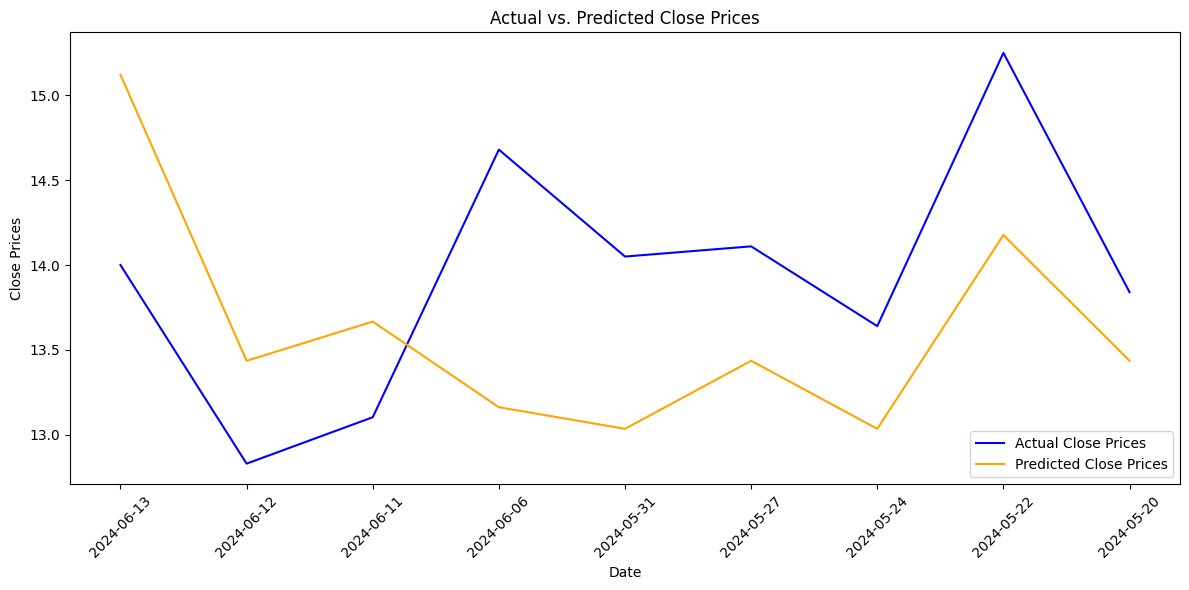

In [10]:
import finnhub
import csv
import datetime
import yfinance as yf
from collections import defaultdict
from pprint import pprint

finnhub_client = finnhub.Client(api_key="cohttk9r01qpcmnifpb0cohttk9r01qpcmnifpbg")

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=2*365)).strftime('%Y-%m-%d')

company_news = finnhub_client.company_news('FRSH', _from=start_date, to=end_date)

aapl = yf.Ticker("FRSH")
aapl_history = aapl.history(start=start_date, end=end_date)
close_prices = aapl_history['Close'].tolist()

date_data = defaultdict(lambda: {'headlines': [], 'summaries': [], 'close_prices': []})
for news_item, price in zip(company_news, close_prices):
    date = datetime.datetime.utcfromtimestamp(news_item['datetime']).strftime('%Y-%m-%d')
    date_data[date]['headlines'].append(news_item['headline'])
    date_data[date]['summaries'].append(news_item['summary'])
    date_data[date]['close_prices'].append(price)

for date, data in date_data.items():
    avg_close_price = sum(data['close_prices']) / len(data['close_prices'])
    date_data[date]['close_price'] = avg_close_price

csv_file = "company_news.csv"

with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['date', 'headline', 'summary', 'close_price'])
    for date, data in date_data.items():
        writer.writerow([date, ", ".join(data['headlines']), ", ".join(data['summaries']), data['close_price']])

print("Data saved to", csv_file)

# print(finnhub_client.stock_symbols('US'))

nltk.download('vader_lexicon')

df = pd.read_csv(csv_file)
df['headline'].fillna('', inplace=True)
df['summary'].fillna('', inplace=True)

sid = SentimentIntensityAnalyzer()
df['Headline_Sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
df['Content_Sentiment'] = df['summary'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

df.to_csv('sentiment_with_scores.csv', index=False)

X = df[['Headline_Sentiment', 'Content_Sentiment']]
y = df['close_price']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

test_preds = model.predict(X_test)

y_test = y_test.reset_index(drop=True)
test_preds = pd.Series(test_preds, name='Predicted')

mse_test = mean_squared_error(y_test, test_preds)
rmse_test = sqrt(mse_test)
mae_test = mean_absolute_error(y_test, test_preds)

range_close = y.max() - y.min()
mse_percentage = (mse_test / range_close) * 100
rmse_percentage = (rmse_test / range_close) * 100
mae_percentage = (mae_test / range_close) * 100

table = [['Metric', 'Error', 'Error Percentage'],
         ['MSE', mse_test, mse_percentage],
         ['RMSE', rmse_test, rmse_percentage],
         ['MAE', mae_test, mae_percentage]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', color='blue')
plt.plot(y_test.index, test_preds, label='Predicted Close Prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()

plt.xticks(y_test.index, df.loc[y_test.index, 'date'], rotation=45)

plt.tight_layout()
plt.show()

